# Step 2: Expanding on the Toy Problem
This is the expandable version of our toy problem. Instead of 4 QBit instances, we now apply the gates to a QArray of 4 qubits, with the S gate being applied to all, and the Y-Rotation gate being applied to certain indexed qubits in the QArray.

In [10]:
from classiq import *
from classiq.execution import ExecutionPreferences
from math import pi

In [11]:
TROTTER_STEPS = 1
THETA_H = 0
SHOTS = 100
QUBITS = 4

The trotter steps were coded by using the trotter decomposition of the time evolution operator in the paper:

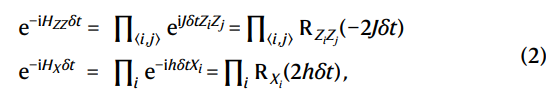

From “Evidence for the utility of quantum computing before fault tolerance”, by Kim Youngseok, Andrew Eddings, et al., 2023, Nature, Vol 618, pg. 501, https://www.nature.com/articles/s41586-023-06096-3

In [14]:
@qfunc
def trotter_step(arr: QArray[QBit]):
    # apply a rotation over the X axis on all qubits with an angle of theta_h
    apply_to_all(lambda q: RX(THETA_H, q), arr)

    # first ZZ layer
    apply_to_all(lambda q: invert(lambda: S(q)), arr)

    within_apply(compute=lambda: RY(pi/2, arr[1]), action=lambda: CX(arr[0], arr[1]))
    within_apply(compute=lambda: RY(pi/2, arr[3]), action=lambda: CX(arr[2], arr[3]))

    # second ZZ layer
    apply_to_all(lambda q: invert(lambda: S(q)), arr)

    within_apply(compute=lambda: RY(pi/2, arr[2]), action=lambda: CX(arr[0], arr[2]))
    within_apply(compute=lambda: RY(pi/2, arr[3]), action=lambda: CX(arr[1], arr[3]))


# Trotterized time evolution function for the multi-qubit QArray
@qfunc
def trotterized_time_evolution(arr: QArray[QBit]):
    for _ in range(TROTTER_STEPS):
      trotter_step(arr)

@qfunc
def main(expectation_value: Output[QBit]):
    # initialize the qubit register
    arr = QArray("reg")
    allocate(QUBITS, arr)

    # setup for measurement of the expectation value
    allocate(1, expectation_value)

    within_apply(lambda: hadamard_transform(expectation_value), lambda: control(expectation_value, lambda: trotterized_time_evolution(arr)))


In [16]:
# Gets the counts of measuring the qubits in their respective states
def synthesize_execute(shots: int):
    quantum_model = set_execution_preferences(
    create_model(main),
    ExecutionPreferences(num_shots=shots),
    )

    quantum_program = synthesize(quantum_model)
    job = execute(quantum_program)
    results = job.result()[0].value.parsed_counts

    return results

# Evaluates the real part of expectation value
def evaluate_real_part(shots):
    print(f"Executing with {shots} shots...")
    result = synthesize_execute(shots)

    if result[0].state["expectation_value"] == 0:
        prob = result[0].shots / shots
    else:
        prob = result[1].shots / shots

    print(f"Measured 0 with probability of {prob*100:.3f}%")

    return 2*prob - 1

This program ran with 100 shots, since this is still just the small width toy problem, we don't expect our results to change by much with more shots.

In [ ]:
# evaluate and print results
value = evaluate_real_part(SHOTS)
print("Expectation value:", value)

Show diagram of the quantum circuit

In [ ]:
qprog = synthesize(create_model(main))
show(qprog)